In [9]:
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from mpl_toolkits.axes_grid1 import make_axes_locatable

sns.set_style("whitegrid")

### Define static values 

In [10]:
folder = "run_results"

# Baseline was estimate using randomly_shuffled_evaluation.py (run 10 x)
baseline = dict({
    "accuracy": 0.2501,
    "kappa": 0.0174,
    "f1-score": 0.1717
})

metrics = ["accuracy", "kappa", "f1-score"]
boxplot_kwargs = {"boxprops": dict(alpha=0.5), "fliersize": 3}
modes = ["central", "federated", "local"]

In [11]:
def get_star_label(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""

## Load data

In [12]:
def load_data(id):
    homo_df = pd.read_csv(os.path.join(folder, f"{id}_homogeneous.csv"))
    homo_df["dataset"] = "homogeneous"
    hetero_df = pd.read_csv(os.path.join(folder, f"{id}_heterogeneous.csv"))
    hetero_df["dataset"] = "heterogeneous"
    TMA_df = pd.read_csv(os.path.join(folder, f"{id}_TMA.csv"))
    TMA_df["dataset"] = "TMA"

    df = pd.concat([homo_df, hetero_df, TMA_df], ignore_index=True)
    return df

def add_local_all(df):
    local_rows = df[df["mode"].str.contains("TMA|spl")].copy()
    local_rows["mode"] = "local"
    df = pd.concat([df, local_rows], ignore_index=True)
    return df

In [13]:
uni_df = load_data("uni")
uni_df["model"] = "UNI"

conch_df = load_data("conch")
conch_df["model"] = "CONCH"

ctranspath_df = load_data("ctranspath")
ctranspath_df["model"] = "CTransPath"

ecarenet_df = add_local_all(load_data("ecarenet"))
ecarenet_df["model"] = "eCaReNet"

full_df = pd.concat([ecarenet_df, ctranspath_df, uni_df, conch_df], ignore_index=True)

In [14]:
full_df.head()

,mode,run_id,best_epoch,replicate,accuracy,kappa,f1-score,test_dataset,accuracy_TMA20,kappa_TMA20,f1-score_TMA20,dataset,model
0,central,297.0,453,1.0,0.548931,0.699276,0.451473,spl_1,0.435897,0.599443,0.370360,homogeneous,eCaReNet
1,central,298.0,208,1.0,0.505062,0.743109,0.452178,spl_2,0.466667,0.644788,0.434281,homogeneous,eCaReNet
2,central,299.0,312,1.0,0.513363,0.689763,0.431824,spl_3,0.476923,0.673405,0.436159,homogeneous,eCaReNet
3,central,306.0,275,2.0,0.554556,0.703341,0.445511,spl_1,0.456410,0.619608,0.395711,homogeneous,eCaReNet
4,central,307.0,103,2.0,0.505062,0.746437,0.444929,spl_2,0.441026,0.666023,0.403101,homogeneous,eCaReNet


## Figure 4

36


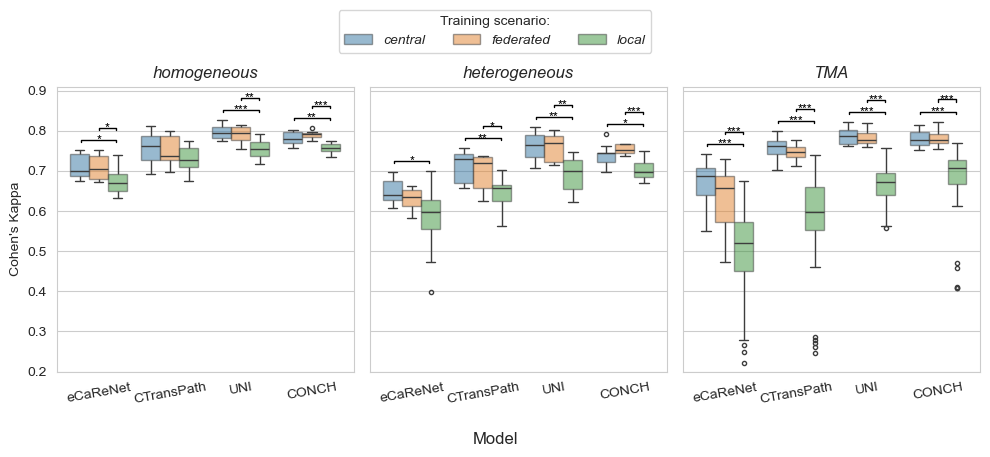

In [33]:
def create_figure4(df, metric):
    df = df[df["mode"].isin(["central", "federated", "local"])]
    fig, axes = plt.subplots(1, 3, figsize=(10, 4), sharey=True)
    all_tests = []

    datasets = df["dataset"].unique()
    models = df["model"].unique()
    mode_order = ["central", "federated", "local"]
    raw_pvals = list()
    for i, dataset in enumerate(datasets):
        t_df = df[df["dataset"] == dataset]
        ax = axes[i]
        sns.boxplot(x="model", y=metric, hue="mode", dodge=True, data=t_df, ax=ax, **boxplot_kwargs)

        ax.axhline(baseline[metric], linestyle="--", linewidth=1)
        ax.set_title(dataset, style="italic")
        ax.set_xlabel("")
        ax.set_ylabel("Cohen's Kappa")
        ax.legend().remove()
        if metric == "kappa":
            ax.set_ylim(bottom=0.2, top=0.91)

        for model in models:
            m_df = t_df[t_df["model"] == model]
            grouped = m_df.groupby("mode")[metric].apply(list)

            for a, b in [("central", "federated"), ("central", "local"), ("federated", "local")]:
                if a in grouped and b in grouped and len(grouped[a]) > 0 and len(grouped[b]) > 0:
                    x1 = models.tolist().index(model) - 0.25 + 0.25 * mode_order.index(a)
                    x2 = models.tolist().index(model) - 0.25 + 0.25 * mode_order.index(b)
                    u_stat, p_val = mannwhitneyu(grouped[a], grouped[b], alternative='two-sided')
                else:
                    p_val = 1.0
                all_tests.append((dataset, model, x1, x2))
                raw_pvals.append(p_val)

    # FDR correction using Benjamin-Hochberg
    print(len(raw_pvals))
    reject, p_adj, _, _ = multipletests(raw_pvals, method="fdr_bh")

    height_increment = 0.03  # vertical space between bars
    base_heights = {}  # stores max boxplot height per (dataset, model)
    # Precompute base heights
    for dataset in datasets:
        for model in models:
            t_df = df[(df["dataset"] == dataset) & (df["model"] == model)]
            base_heights[(dataset, model)] = t_df[metric].max() + 0.02  # base level above whisker

    annotation_counts = {}  # tracks how many annotations already plotted
    for i, (dataset, model, x1, x2) in enumerate(all_tests):
        p_corrected = p_adj[i]
        sig = get_star_label(p_corrected)
        if not sig:
            continue

        key = (dataset, model)
        level = annotation_counts.get(key, 0)
        y = base_heights[key] + level * height_increment
        annotation_counts[key] = level + 1
        ax = axes[list(datasets).index(dataset)]
        ax.plot([x1, x1, x2, x2], [y, y + 0.005, y + 0.005, y], lw=1, c="k")
        ax.text((x1 + x2) / 2, y + 0.002, f"{sig}", ha="center", va="center", color="k", fontsize=9)

    for ax in axes:
        ax.tick_params(axis='x', rotation=10)

    fig.supxlabel("Model")
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles[:3], labels[:3], loc="upper center", title="Training scenario:", ncol=3, bbox_to_anchor=(0.5, 1.12), prop={'style': 'italic'})
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig(os.path.join(folder, f"Compare_models_{metric}.png"), dpi=600, bbox_inches="tight")

create_figure4(full_df, "kappa")

In [16]:
heat_ecarenet_df = pd.read_csv(os.path.join(folder, f"ecarenet_TMA.csv"))
heat_ecarenet_df["test_dataset"] = heat_ecarenet_df["test_dataset"].replace({"TMA14": "TMA 14", "TMA15": "TMA 15", "TMA16": "TMA 16", "TMA17": "TMA 17", "TMA18": "TMA 18", "TMA19": "TMA 19", "TMA20": "TMA 20"})
heat_ecarenet_df["model"] = "eCaReNet"
heat_ctranspath_df = pd.read_csv(os.path.join(folder, f"ctranspath_TMA_heat.csv"))
heat_ctranspath_df["model"] = "CTransPath"
heat_uni_df = pd.read_csv(os.path.join(folder, f"uni_TMA_heat.csv"))
heat_uni_df["model"] = "UNI"
heat_conch_df = pd.read_csv(os.path.join(folder, f"conch_TMA_heat.csv"))
heat_conch_df["model"] = "CONCH"
heatmap_df = pd.concat([heat_uni_df, heat_ctranspath_df, heat_conch_df, heat_ecarenet_df])
heatmap_df["mode"] = heatmap_df["mode"].str.replace("_", " ", regex=False)
heatmap_df["test_dataset"] = heatmap_df["test_dataset"].str.replace("_", " ", regex=False)

In [17]:
def heatmap_metric(df, metric):
    fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), sharey=True)
    divider = make_axes_locatable(axes[-1])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    vmin = df[metric].min()
    vmax = df[metric].max()

    for i, m in enumerate(["eCaReNet", "CTransPath", "UNI", "CONCH"]):
        t_df = df[df["model"] == m]
        t_df = t_df.groupby(['mode', 'test_dataset'], as_index=False)[metric].mean()
        pivot = t_df.pivot(index='mode', columns='test_dataset', values=metric)

        sns.heatmap(pivot, annot=True, fmt=".2f", cmap="cividis", ax=axes[i], cbar=(i == 3), cbar_ax=(cax if i == 3 else None), vmin=vmin, vmax=vmax, annot_kws={"size": 8})
        axes[i].set_title(m)
        axes[i].set_xlabel("Testset")
        axes[i].set_ylabel("")

    axes[0].set_ylabel("Training mode")
    cax.set_ylabel(metric.capitalize(), rotation=90, labelpad=5)

    plt.tight_layout()
    plt.savefig(os.path.join("hue_sat_val", f"{metric}_heatmap.png"), dpi=600)
    plt.close()

In [18]:
heatmap_metric(heatmap_df, "kappa")

In [19]:
for i, m in enumerate(["eCaReNet", "CTransPath", "UNI", "CONCH"]):
    print()
    print(f"Maximum difference between the best and worst model performance for {m}")
    t_df = heatmap_df[heatmap_df["model"] == m]
    t_df = t_df.groupby(['mode', 'test_dataset'], as_index=False)["kappa"].mean()
    for mode in ["central", "federated"]:
        tt_df = t_df[t_df["mode"] == mode]        
        diff = max(tt_df["kappa"]) - min(tt_df["kappa"])
        print(f"In the {mode} scenario the difference between best and worst is {diff:.2f}.")

    #print(t_df)


Maximum difference between the best and worst model performance for eCaReNet
In the central scenario the difference between best and worst is 0.12.
In the federated scenario the difference between best and worst is 0.20.

Maximum difference between the best and worst model performance for CTransPath
In the central scenario the difference between best and worst is 0.05.
In the federated scenario the difference between best and worst is 0.05.

Maximum difference between the best and worst model performance for UNI
In the central scenario the difference between best and worst is 0.04.
In the federated scenario the difference between best and worst is 0.04.

Maximum difference between the best and worst model performance for CONCH
In the central scenario the difference between best and worst is 0.04.
In the federated scenario the difference between best and worst is 0.04.


In [20]:
for i, m in enumerate(["eCaReNet", "CTransPath", "UNI", "CONCH"]):
    print()
    print(f"Maximum difference between the best and worst model performance for {m}")
    t_df = heatmap_df[heatmap_df["model"] == m]
    t_df = t_df.groupby(['mode', 'test_dataset'], as_index=False)["kappa"].mean()
    
    tt_df = t_df[~t_df["mode"].isin(["central", "federated"])]
    diff = max(tt_df["kappa"]) - min(tt_df["kappa"])
    print(f"In the {mode} scenario the difference between best and worst is {diff:.2f}.")



Maximum difference between the best and worst model performance for eCaReNet
In the federated scenario the difference between best and worst is 0.41.

Maximum difference between the best and worst model performance for CTransPath
In the federated scenario the difference between best and worst is 0.43.

Maximum difference between the best and worst model performance for UNI
In the federated scenario the difference between best and worst is 0.16.

Maximum difference between the best and worst model performance for CONCH
In the federated scenario the difference between best and worst is 0.20.


## Results

In [21]:
def average_drop_mode(df, metric):
    t_df = df[df["mode"].isin(["central", "federated", "local"])]
    t_df = t_df[t_df["dataset"] == "homogeneous"]
    average_metric = t_df.groupby(['mode', 'model'])[metric].mean().reset_index()
    pivoted = average_metric.pivot(index='model', columns='mode', values=metric)
    cent = (pivoted["local"] - pivoted["central"]) / pivoted["central"] * 100
    fed = (pivoted["local"] - pivoted["federated"]) / pivoted["federated"] * 100

    mi = min(min(cent), min(fed))
    ma = max(max(cent), max(fed))

    print(f"average performance increases between {mi:.1f}% and {ma:.1f}% for the local runs")

average_drop_mode(full_df, "accuracy")
average_drop_mode(full_df, "kappa")
average_drop_mode(full_df, "f1-score")

average performance increases between -10.3% and -2.0% for the local runs
average performance increases between -5.4% and -2.8% for the local runs
average performance increases between -10.5% and -5.0% for the local runs


In [22]:
def average_drop_models(df, metric):
    t_df = df[df["mode"].isin(["central", "federated", "local"])]
    t_df = t_df[t_df["dataset"] == "homogeneous"]
    average_metric = t_df.groupby(["mode", "model"])[metric].mean().reset_index()
    pivoted = average_metric.pivot(index='mode', columns='model', values=metric)
    uni = (pivoted["UNI"] - pivoted["eCaReNet"]) / pivoted["eCaReNet"] * 100
    conch = (pivoted["CONCH"] - pivoted["eCaReNet"]) / pivoted["eCaReNet"] * 100
    ctranspath = (pivoted["CTransPath"] - pivoted["eCaReNet"]) / pivoted["eCaReNet"] * 100

    mi = min(min(ctranspath), min(uni), min(conch))
    ma = max(max(ctranspath), max(uni), max(conch))

    print(f"Average performance increases for foundation models between {mi:.1f}% and {ma:.1f}% compared to eCaReNet")

average_drop_models(full_df, "accuracy")
average_drop_models(full_df, "kappa")
average_drop_models(full_df, "f1-score")

Average performance increases for foundation models between 8.1% and 17.4% compared to eCaReNet
Average performance increases for foundation models between 5.8% and 12.3% compared to eCaReNet
Average performance increases for foundation models between 27.2% and 36.3% compared to eCaReNet


In [23]:
def average_drop_datasplits(df):
    t_df = df[df["mode"].isin(["central", "federated", "local"])]

    for model in t_df["model"].unique():
        tma_l = list()
        hetero_l = list()
        for metric in ["accuracy", "kappa", "f1-score"]:
            average_metric = t_df.groupby(["mode", "model", "dataset"])[metric].mean().reset_index()
            temp = average_metric[average_metric["model"] == model]
            pivoted = temp.pivot(index='mode', columns='dataset', values=metric)

            hetero = (pivoted["heterogeneous"] - pivoted["homogeneous"]) / pivoted["homogeneous"] * 100
            tma = (pivoted["TMA"] - pivoted["homogeneous"]) / pivoted["homogeneous"] * 100
            hetero_l.extend(hetero)
            tma_l.extend(tma)

        print(f"For model: {model}")
        print(f"Heterogenous data split mean performance increase {np.mean(hetero_l):.0f}%")
        print(f"TMA data split mean performance increase {np.mean(tma_l):.0f}%")
        print()

average_drop_datasplits(full_df)

For model: eCaReNet
Heterogenous data split mean performance increase -13%
TMA data split mean performance increase -13%

For model: CTransPath
Heterogenous data split mean performance increase -10%
TMA data split mean performance increase -8%

For model: UNI
Heterogenous data split mean performance increase -9%
TMA data split mean performance increase -5%

For model: CONCH
Heterogenous data split mean performance increase -9%
TMA data split mean performance increase -4%



In [24]:
def drop_ecarenet_federated(df):
    t_df = df[df["mode"].isin(["central", "federated", "local"])]
    t_df = t_df[t_df["model"] == "eCaReNet"]

    central_l = list()
    local_l = list()
    for metric in ["accuracy", "kappa", "f1-score"]:
        temp = t_df.groupby(["mode", "model", "dataset"])[metric].mean().reset_index()
        pivoted = temp.pivot(index='dataset', columns='mode', values=metric)

        central = (pivoted["federated"] - pivoted["central"]) / pivoted["central"] * 100
        local = (pivoted["federated"] - pivoted["local"]) / pivoted["local"] * 100
        central_l.extend(central)
        local_l.extend(local)

        
    print(f"Federated models perform {np.mean(central_l):.1f}% better than central models")
    print(f"Federated models perform {np.mean(local_l):.1f}% better than local models")
    print()

drop_ecarenet_federated(full_df)

Federated models perform -5.7% better than central models
Federated models perform 9.3% better than local models



In [25]:
def performance_range_local(df):
    t_df = df[df["mode"].isin(["local"])]
    t_df = t_df[t_df["model"] == "eCaReNet"]

    for metric in ["accuracy", "kappa", "f1-score"]:
        mi = t_df[metric].min()
        ma = t_df[metric].max()
        
        print(metric)
        print(f"Max performance {np.mean(mi):.5f}")
        print(f"Min performance {np.mean(ma):.5f}")
        print(f"Range: {ma-mi:.2f}")
        print()

performance_range_local(full_df)

accuracy
Max performance 0.24803
Min performance 0.52418
Range: 0.28

kappa
Max performance 0.22185
Min performance 0.73970
Range: 0.52

f1-score
Max performance 0.16465
Min performance 0.45926
Range: 0.29



## Supplement

In [26]:
def get_pivot(df, metric):
    grouped = df.groupby(["dataset", "mode", "model"])[metric].agg(["mean", "std"]).reset_index()
    grouped["mean"] = grouped["mean"].round(2)
    grouped["std"] = grouped["std"].round(3)

    pivot = grouped.pivot_table(index=["dataset", "mode"], columns="model", values=["mean", "std"])
    pivot.columns = [f"{model}_{stat}" for stat, model in pivot.columns]

    column_order = ["eCaReNet_mean", "eCaReNet_std", "CTransPath_mean", "CTransPath_std", "UNI_mean", "UNI_std", "CONCH_mean", "CONCH_std"]
    pivot = pivot[column_order]
    print(pivot)

table_df = full_df[~full_df["mode"].str.startswith(("TMA", "spl"))]
get_pivot(table_df, "accuracy")
get_pivot(table_df, "kappa")
get_pivot(table_df, "f1-score")

                         eCaReNet_mean  eCaReNet_std  CTransPath_mean  \
dataset       mode                                                      
TMA           central             0.52         0.032             0.57   
              federated           0.45         0.048             0.57   
              local               0.41         0.060             0.44   
heterogeneous central             0.47         0.052             0.53   
              federated           0.45         0.061             0.50   
              local               0.43         0.069             0.45   
homogeneous   central             0.53         0.020             0.57   
              federated           0.51         0.025             0.57   
              local               0.50         0.015             0.54   

                         CTransPath_std  UNI_mean  UNI_std  CONCH_mean  \
dataset       mode                                                       
TMA           central             0.020      0.6

108
108


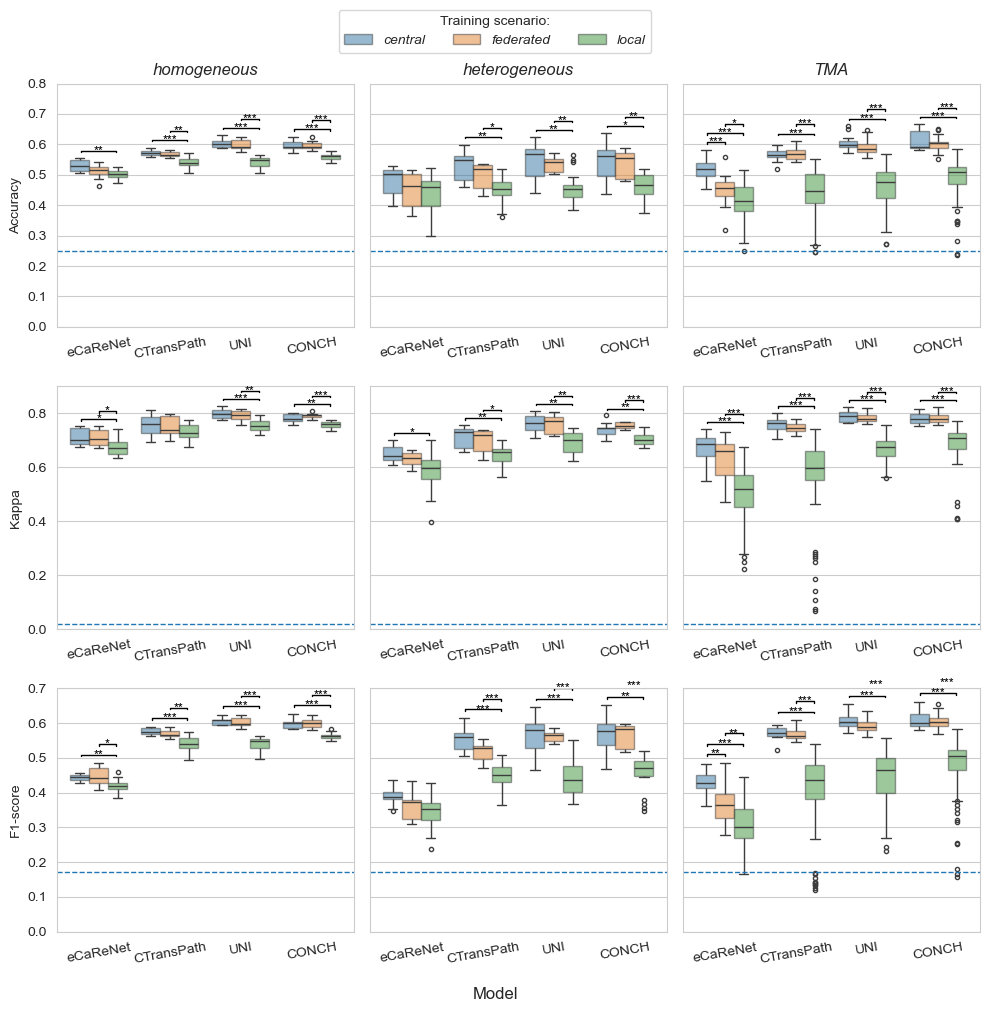

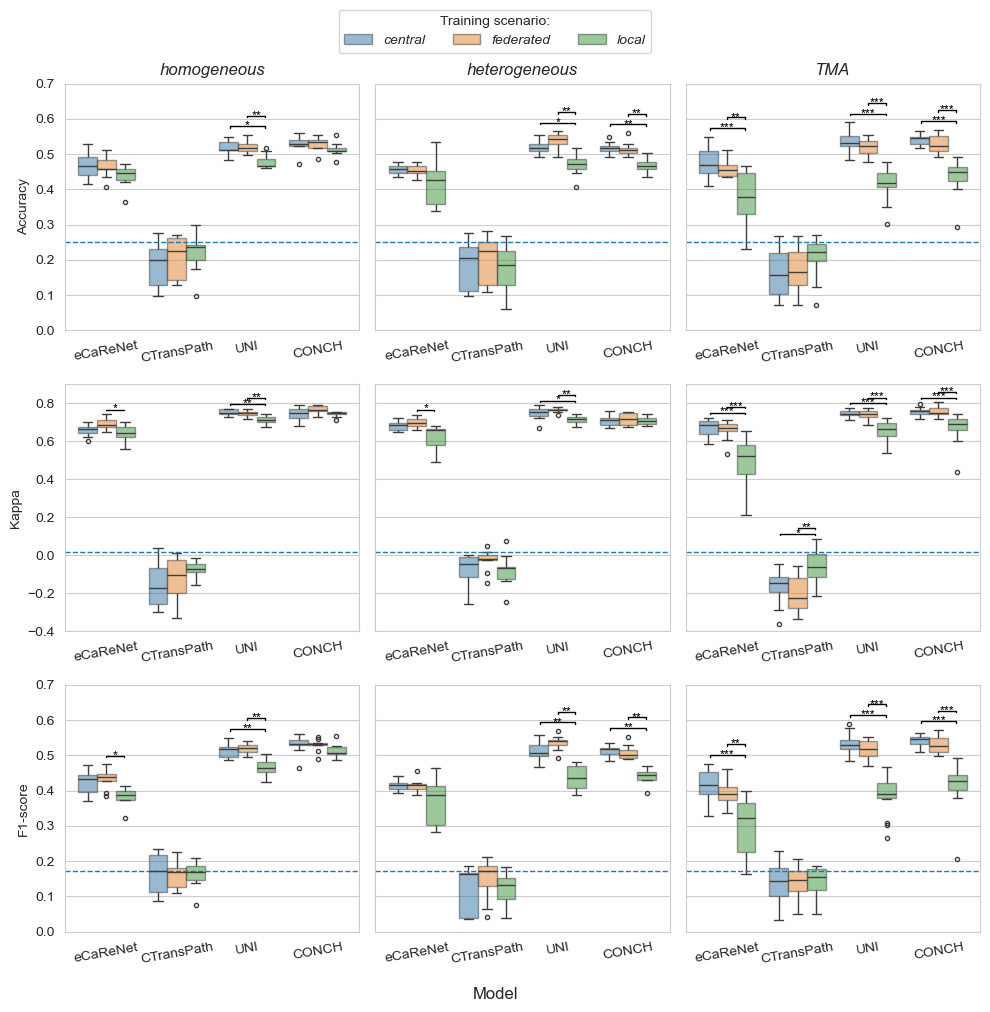

In [32]:
def create_supp_figure(df, use_tma20=False):
    df = df[df["mode"].isin(["central", "federated", "local"])]
    fig, axes = plt.subplots(3, 3, figsize=(10, 9), sharey="row")
    all_tests = []

    datasets = df["dataset"].unique()
    models = df["model"].unique()
    mode_order = ["central", "federated", "local"]
    raw_pvals = []

    for i, metric in enumerate(["accuracy", "kappa", "f1-score"]):
        metric_col = f"{metric}_TMA20" if use_tma20 else metric

        for j, dataset in enumerate(datasets):
            t_df = df[df["dataset"] == dataset]
            ax = axes[i][j]

            sns.boxplot(x="model", y=metric_col, hue="mode", dodge=True, data=t_df, ax=ax, **boxplot_kwargs)
            ax.axhline(baseline[metric], linestyle="--", linewidth=1)
            ax.set_xlabel("")
            ax.set_ylabel("")
            ax.legend().remove()
            if i == 0:
                ax.set_title(dataset, style="italic")

            for model in models:
                m_df = t_df[t_df["model"] == model]
                grouped = m_df.groupby("mode")[metric_col].apply(list)
                for a, b in [("central", "federated"), ("central", "local"), ("federated", "local")]:
                    if a in grouped and b in grouped and len(grouped[a]) > 0 and len(grouped[b]) > 0:
                        x1 = models.tolist().index(model) - 0.25 + 0.25 * mode_order.index(a)
                        x2 = models.tolist().index(model) - 0.25 + 0.25 * mode_order.index(b)
                        list_a = [x for x in grouped[a] if x == x] # remove NaN's for TMA_20 dataset
                        list_b = [x for x in grouped[b] if x == x] # remove NaN's for TMA_20 dataset
                        u_stat, p_val = mannwhitneyu(list_a, list_b, alternative='two-sided')
                    else:
                        p_val = 1.0
                    all_tests.append((i, j, metric, dataset, model, x1, x2))
                    raw_pvals.append(p_val)

    # FDR correction
    print(len(raw_pvals))
    reject, p_adj, _, _ = multipletests(raw_pvals, method="fdr_bh")

    height_increment = 0.03
    base_heights = {}
    for i, metric in enumerate(["accuracy", "kappa", "f1-score"]):
        metric_col = f"{metric}_TMA20" if use_tma20 else metric
        for dataset in datasets:
            for model in models:
                t_df = df[(df["dataset"] == dataset) & (df["model"] == model)]
                base_heights[(i, dataset, model)] = t_df[metric_col].max() + 0.02 if not t_df.empty else 0.1

    annotation_counts = {}
    for i, (m_idx, d_idx, metric, dataset, model, x1, x2) in enumerate(all_tests):
        p_corrected = p_adj[i]
        sig = get_star_label(p_corrected)
        if not sig:
            continue

        key = (m_idx, dataset, model)
        level = annotation_counts.get(key, 0)
        y = base_heights[key] + level * height_increment
        annotation_counts[key] = level + 1

        ax = axes[m_idx][d_idx]
        ax.plot([x1, x1, x2, x2], [y, y + 0.005, y + 0.005, y], lw=1, c="k")
        ax.text((x1 + x2) / 2, y + 0.002, f"{sig}", ha="center", va="center", color="k", fontsize=9)

    for axs in axes:
        for ax in axs:
            ax.tick_params(axis='x', rotation=10)

    
    if use_tma20:
        axes[0][0].set_ylim(top=0.7, bottom=0.0)
        axes[1][0].set_ylim(top=0.9, bottom=-0.4)
    else:
        axes[0][0].set_ylim(top=0.8, bottom=0.0)
        axes[1][0].set_ylim(top=0.9, bottom=0.0)
    axes[2][0].set_ylim(top=0.7, bottom=0.0)
    axes[0][0].set_ylabel("Accuracy")
    axes[1][0].set_ylabel("Kappa")
    axes[2][0].set_ylabel("F1-score")
    fig.supxlabel("Model")



    handles, labels = axes[0][0].get_legend_handles_labels()
    fig.legend(handles[:3], labels[:3], loc="upper center", title="Training scenario:", ncol=3, bbox_to_anchor=(0.5, 1.12), prop={'style': 'italic'})

    plt.tight_layout(rect=[0, 0, 1, 1.07])
    filename = "Supp_compare_models_TMA20.png" if use_tma20 else "Supp_compare_models.png"
    plt.savefig(os.path.join(folder, filename), dpi=600, bbox_inches="tight")

create_supp_figure(full_df)
create_supp_figure(full_df, use_tma20=True)

In [ ]:
def heatmap_metric_supp(df, metrics):
    assert len(metrics) == 2, "Provide exactly two metrics"

    fig, axes = plt.subplots(2, 4, figsize=(10, 5), sharey=True)
    
    for row, metric in enumerate(metrics):
        # Normalize color scale across all models for the current metric
        vmin = df[metric].min()
        vmax = df[metric].max()

        for col, model in enumerate(["eCaReNet", "CTransPath", "UNI", "CONCH"]):
            ax = axes[row, col]
            t_df = df[df["model"] == model]
            t_df = t_df.groupby(['mode', 'test_dataset'], as_index=False)[metric].mean()
            pivot = t_df.pivot(index='mode', columns='test_dataset', values=metric)

            # Only last column in the row gets the colorbar
            if col == 3:
                divider = make_axes_locatable(ax)
                cax = divider.append_axes("right", size="5%", pad=0.05)
                show_cbar = True
            else:
                cax = None
                show_cbar = False

            sns.heatmap(pivot, annot=True, fmt=".2f", cmap="cividis",
                        ax=ax, cbar=show_cbar, cbar_ax=cax,
                        vmin=vmin, vmax=vmax, annot_kws={"size": 8})

            if row == 0:
                ax.set_title(model)
            ax.set_xlabel("Testset")
            ax.set_ylabel("Training mode" if col == 0 else "")
            if show_cbar:
                cax.set_ylabel(metric.capitalize(), rotation=90, labelpad=5)

    plt.tight_layout()
    plt.savefig(os.path.join("hue_sat_val", f"heatmap_supp.png"), dpi=600)
    plt.close()

In [ ]:
heatmap_metric_supp(heatmap_df, ["accuracy", "f1-score"])

## Discussion

In [ ]:
def direct_comparisions(df, dataset):
    print()
    print(dataset)
    df = df[df["dataset"] == dataset]
    for model in df["model"].unique():
        t_df = df[df["model"] == model]
        
        cent = t_df[t_df["mode"] == "central"]
        fed = t_df[t_df["mode"] == "federated"]
        local = t_df[t_df["mode"] == "local"]
        
        results = list()
        for m in metrics:
            l_m = local[m].mean()
            c_m = cent[m].mean()
            f_m = fed[m].mean()

            l_f_diff = (f_m - l_m) / f_m*100
            l_c_diff = (c_m - l_m) / c_m*100
            results.extend([l_f_diff, l_c_diff])

        print(f"{model}\t{min(results):.0f}% - {max(results):.0f}%")


direct_comparisions(full_df, "homogeneous")
direct_comparisions(full_df, "heterogeneous")
direct_comparisions(full_df, "TMA")


homogeneous
eCaReNet	2% - 6%
CTransPath	3% - 6%
UNI	5% - 11%
CONCH	3% - 6%

heterogeneous
eCaReNet	4% - 12%
CTransPath	7% - 20%
UNI	9% - 22%
CONCH	5% - 19%

TMA
eCaReNet	9% - 28%
CTransPath	22% - 29%
UNI	15% - 26%
CONCH	12% - 22%


In [ ]:
def performance_range(df, dataset):
    t_df = df[df["dataset"] == dataset]

    fed = t_df[t_df["mode"] == "federated"]
    local = t_df[t_df["mode"] == "local"]
    
    local_results = list()
    fed_results = list()
    for m in metrics:
        l_range = local[m].max() - local[m].min()
        f_range = fed[m].max() - fed[m].min()

        local_results.append(l_range)
        fed_results.append(f_range)

    print(dataset)
    print(f"fed range\t{sum(fed_results)/len(fed_results):.2f}")
    print(f"local range\t{sum(local_results)/len(local_results):.2f}")

    return

performance_range(full_df, "heterogeneous")
performance_range(full_df, "TMA")

heterogeneous
fed range	0.24
local range	0.31
TMA
fed range	0.35
local range	0.51


## Compare model sizes

In [ ]:
ecarenet = 3470821
ctranspath = 24837
UNI = 49413
CONCH = 16709

print((ctranspath - ecarenet) / ecarenet * 100)
print((UNI - ecarenet) / ecarenet * 100)
print((CONCH - ecarenet) / ecarenet * 100)

UNIv2 = 681394176

-99.28440562045695
-98.5763310755582
-99.51858652462919
